## Setup

Requirements:


In [1]:
#Load Packages
import pandas as pd
import numpy as np
import patsy as pt
import plotly.express as px
import nbformat
import plotly as py
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
import statsmodels.api as sm
import statsmodels.tsa.stattools as st


In [2]:
#Load Data
data = pd.read_csv("data/amazon-purchases.csv")
survey_data = pd.read_csv("data/survey.csv")

# Data Pre-Processing

In [3]:
#Add a prime purchase column to the data

#Create a list with prime days inside it
prime_days = ["2022-07-12", "2022-07-13", "2021-06-21", "2021-06-22", "2020-10-13", "2020-10-14", "2019-07-15", "2019-07-16", "2018-07-17", "2018-07-18",]

prime_purchase = []
for i in data["Order Date"]:
    if i in prime_days:
        prime_purchase.append(1)
    else:
        prime_purchase.append(0)
data["Prime Purchase"] = prime_purchase

In [4]:
#Use prime purchase data to create a prime day customer list
prime_day_customer = []
for i in range(len(data)):
    if data["Prime Purchase"][i] == 1:
        prime_day_customer.append(data["Survey ResponseID"][i])
prime_day_customer = set(prime_day_customer)

prime_customer = []
for i in data["Survey ResponseID"]:
    if i in prime_day_customer:
        prime_customer.append(1)
    else:
        prime_customer.append(0)

data["Prime Customer"] = prime_customer

In [5]:
# Merge the purchase data with customer surveys on 'Survey ResponseID'
merged_data = pd.merge(data, survey_data, on='Survey ResponseID', how='inner')

In [6]:
subset_data = merged_data[(merged_data['Q-demos-gender'] == 'Female') & (merged_data['Q-demos-age'] != '65 and older') & (merged_data['Prime Customer'] == 1) & (merged_data['Q-amazon-use-howmany']=='1 (just me!)') & (merged_data['Order Date']<'2022-12-21')]

In [7]:
#Calculate Revenue to use in forecast
subset_data['Revenue'] = subset_data['Quantity'] * subset_data['Purchase Price Per Unit']

C:\Users\nicko\AppData\Local\Temp\ipykernel_2620\2637245334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Revenue'] = subset_data['Quantity'] * subset_data['Purchase Price Per Unit']


In [8]:
subset_data['Order Date'].max()

'2022-12-20'

Data exploration

In [101]:
# Convert 'Order Date' to datetime
subset_data['Order Date'] = pd.to_datetime(subset_data['Order Date'])

# Group by 'Order Date' and sum the 'Purchase Price Per Unit'
transaction_totals = subset_data.groupby(['Order Date'])['Purchase Price Per Unit'].sum().reset_index()

# Plot the time series
px.line(transaction_totals, x='Order Date', y='Purchase Price Per Unit', title='Transaction Totals Over Time')

C:\Users\nicko\AppData\Local\Temp\ipykernel_2620\3692892032.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Aggregate Data for Modeling

In [106]:
# Group by Date and aggregate the quantity and purchase prices
aggregated_data = subset_data.groupby(['Order Date']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'Prime Purchase': lambda x: 1 if x.sum() > 0 else 0,
    'Prime Customer': 'sum'
}).reset_index()

#Add a column for the year, month, day, and day of the week
aggregated_data['Year'] = aggregated_data['Order Date'].dt.year
aggregated_data['Month'] = aggregated_data['Order Date'].dt.month
aggregated_data['Day'] = aggregated_data['Order Date'].dt.day
aggregated_data['Day of Week'] = aggregated_data['Order Date'].dt.dayofweek

# Display the first few rows of the aggregated data
aggregated_data['prime_proportion'] = aggregated_data['Prime Customer'] / aggregated_data['Quantity']
aggregated_data.head()

,Order Date,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
0,2018-01-01,201.0,3091.23,0,189,2018,1,1,0,0.940299
1,2018-01-02,173.0,2986.71,0,159,2018,1,2,1,0.919075
2,2018-01-03,184.0,3325.05,0,163,2018,1,3,2,0.885870
3,2018-01-04,181.0,3286.29,0,167,2018,1,4,3,0.922652
4,2018-01-05,142.0,3786.45,0,126,2018,1,5,4,0.887324


In [107]:
aggregated_data['prime_proportion'].describe()

count    1815.000000
mean        0.928723
std         0.039225
min         0.452652
25%         0.913956
50%         0.934426
75%         0.951378
max         1.000000
Name: prime_proportion, dtype: float64

# Specify and Prepare the Model Type

In [100]:
#Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
import plotly_express as px

In [ ]:
#Create a series to feed to the exponential smoothing model
revenue = aggregated_data['Revenue']
revenue.index = aggregated_data['Order Date']

#Run a model with a 30 day seasonal period and an additive trend and seasonal component
expModel = ExponentialSmoothing(revenue, trend='add', seasonal='add', seasonal_periods=30).fit()

#Forecast 90 days into the future
expForecast = expModel.forecast(90)

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [104]:
expModel.summary()

Dep. Variable:,Revenue,No. Observations:,1815
Model:,ExponentialSmoothing,SSE,8488839258.791
Optimized:,True,AIC,27943.092
Trend:,Additive,BIC,28130.222
Seasonal:,Additive,AICC,27944.590
Seasonal Periods:,30,Date:,"Wed, 18 Dec 2024"
Box-Cox:,False,Time:,19:22:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1464286,alpha,True
smoothing_trend,0.0001,beta,True


In [ ]:
import plotly.graph_objects as go

# Create a DataFrame with the actual revenue and the forecasts
smoothData = pd.DataFrame({
        'Truth': revenue.values,
        'Model': expModel.fittedvalues
}, index=revenue.index)

# Add the forecasts to the DataFrame
forecast_dates = pd.date_range(start=revenue.index[-1], periods=90, freq='D')
forecast_df = pd.DataFrame({
        'Forecast': expForecast
}, index=forecast_dates)

# Combine the actual and forecast data
combined_data = pd.concat([smoothData, forecast_df])

# Plot the data
fig = px.line(combined_data, y=['Truth', 'Model', 'Forecast'], 
              title='Exponential Smoothing Forecast', 
              labels={'value': 'Revenue', 'variable': 'Type'},
                          x=combined_data.index,
                          color_discrete_map={
                                  "Truth": 'blue',
                                  'Model': 'red',
                                  'Forecast': 'red'
                          })

fig.show()

GAMs

In [19]:
#Abhi's GAM
#!pip install pygam

In [ ]:
from sklearn.model_selection import train_test_split

aggregated_data['Weekday'] = aggregated_data['Order Date'].dt.dayofweek
aggregated_data.set_index('Order Date', inplace=True)
x = aggregated_data[["Year", "Month", "Day", "Weekday", "prime_proportion"]]
y = aggregated_data["Revenue"]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     45.5985
Link Function:                     IdentityLink Log Likelihood:                                 -29444.844
Number of Samples:                         1815 AIC:                                            58982.8851
                                                AICc:                                            58985.395
                                                GCV:                                          4640271.8069
                                                Scale:                                        4430911.6793
                                                Pseudo R-Squared:                                   0.3961
Feature Function                  Lam

C:\Users\nicko\AppData\Local\Temp\ipykernel_2620\1876165514.py:7: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




<Figure size 640x480 with 0 Axes>

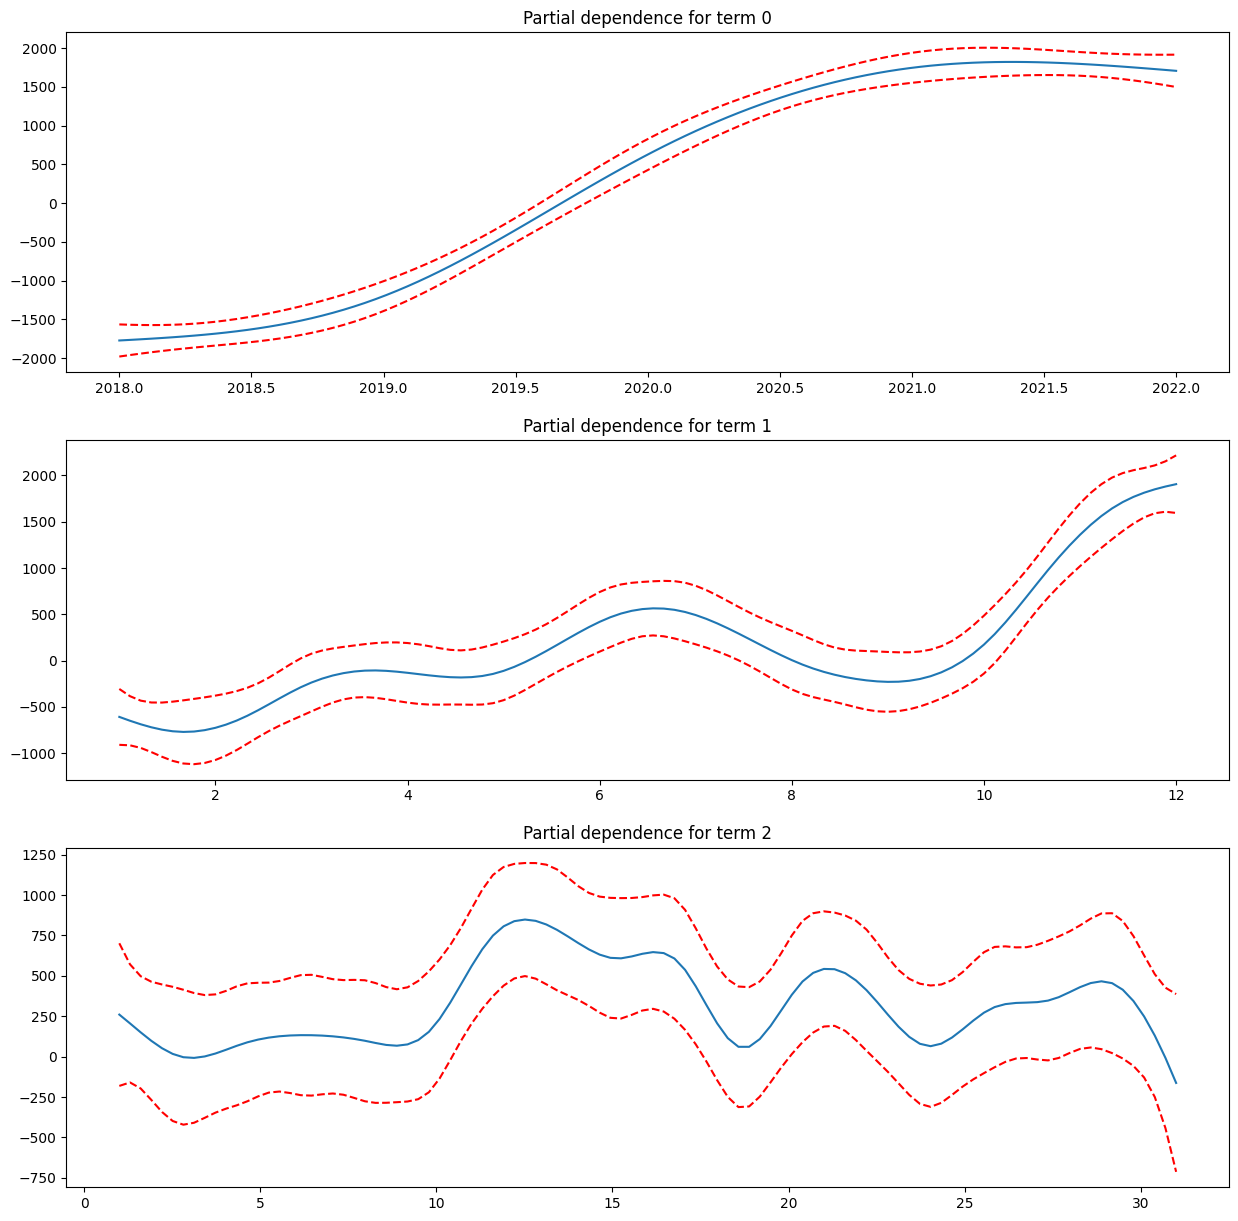

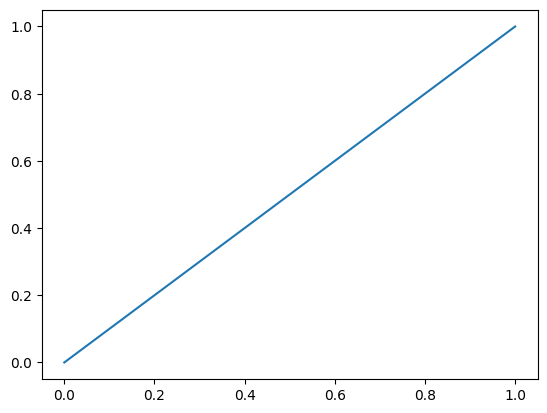

[[2018.            0.            0.            0.            0.        ]
 [2018.04040404    0.            0.            0.            0.        ]
 [2018.08080808    0.            0.            0.            0.        ]
 [2018.12121212    0.            0.            0.            0.        ]
 [2018.16161616    0.            0.            0.            0.        ]
 [2018.2020202     0.            0.            0.            0.        ]
 [2018.24242424    0.            0.            0.            0.        ]
 [2018.28282828    0.            0.            0.            0.        ]
 [2018.32323232    0.            0.            0.            0.        ]
 [2018.36363636    0.            0.            0.            0.        ]
 [2018.4040404     0.            0.            0.            0.        ]
 [2018.44444444    0.            0.            0.            0.        ]
 [2018.48484848    0.            0.            0.            0.        ]
 [2018.52525253    0.            0.            0.  

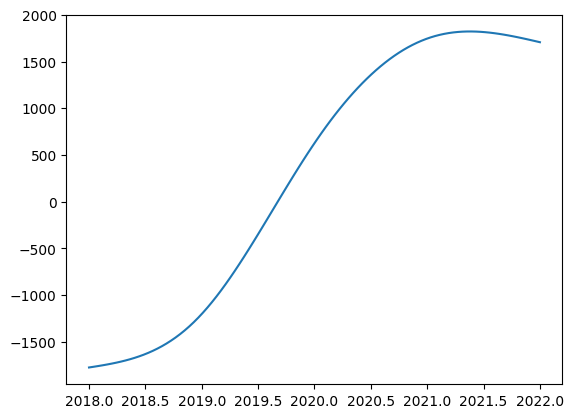

In [24]:
from pygam import LinearGAM

# Assuming gam is your trained LinearGAM model
gam = LinearGAM().fit(x, y)

# Plot partial dependence
gam.summary()  # Summary should list all feature splines

# Plot each term (feature)
import matplotlib.pyplot as plt
plt.figure()
fig, axs = plt.subplots(nrows=3, figsize=(15, 15))  # Adjust nrows to the number of features

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(f"Partial dependence for term {i}")
plt.show()

import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1])
plt.show()

XX = gam.generate_X_grid(term=0)
print(XX)
pd = gam.partial_dependence(term=0, X=XX)
plt.plot(XX[:, 0], pd)
plt.show()

In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Select only the first two columns of x_test
x_test_selected = x_test.iloc[:, :5]

y_pred = gam.predict(x_test_selected)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)

R^2: 0.4783714613307575
MAE: 1018.6441713948336
RMSE: 1793.360742933473


In [26]:
x_test_selected

,Year,Month,Day,Weekday,prime_proportion
567,2019,7,22,0,0.934783
432,2019,3,9,5,0.942308
1750,2022,10,17,0,0.914956
674,2019,11,6,2,0.911111
111,2018,4,22,6,0.973404
...,...,...,...,...,...
1125,2021,1,30,5,0.914894
1142,2021,2,16,1,0.928977
1512,2022,2,21,0,0.921466
170,2018,6,20,2,0.951351


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

endDate = pd.to_datetime("2022-12-21")
# Generate dates for the next 3 months
future_dates = pd.date_range(start=endDate, periods=90, freq="D")

# Generate the same features as used in the training data
future_features = pd.DataFrame({
    "Year": future_dates.year,
    "Month": future_dates.month,
    "Day": future_dates.day,
    "Weekday": future_dates.weekday,
    "prime_proportion": 0.5  # Assume 50% prime customers
})

# Assume `gam` is your trained LinearGAM model
future_predictions = gam.predict(future_features)

# Get confidence intervals
intervals = gam.prediction_intervals(future_features, width=0.95)
lower = intervals[:, 0]  # Lower bounds
upper = intervals[:, 1]  # Upper bounds

# Plot the results
import plotly.express as px

fig = px.line(x=future_dates, y=future_predictions, labels={'x': 'Date', 'y': 'Revenue'}, title='Predicted Daily Revenue for the Next 3 Months')
fig.add_scatter(x=future_dates, y=lower, mode='lines', line=dict(color='gray'), name='Lower Bound')
fig.add_scatter(x=future_dates, y=upper, mode='lines', line=dict(color='gray'), name='Upper Bound', fill='tonexty')
fig.show()

# Save predictions to a CSV
# predictions_df = pd.DataFrame({
#     "date": future_dates,
#     "predicted_revenue": future_predictions,
#     "lower_bound": lower,
#     "upper_bound": upper
# })
# predictions_df.to_csv("revenue_predictions.csv", index=False)

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 1815
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14848.212
Date:                           Wed, 18 Dec 2024   AIC                          29712.425
Time:                                   13:35:12   BIC                          29756.420
Sample:                               01-01-2018   HQIC                         29728.662
                                    - 12-20-2022                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
prime_proportion -2280.4710    508.630     -4.484      0.000   -3277.368   -1283.574
Prime Purchase    5571.55

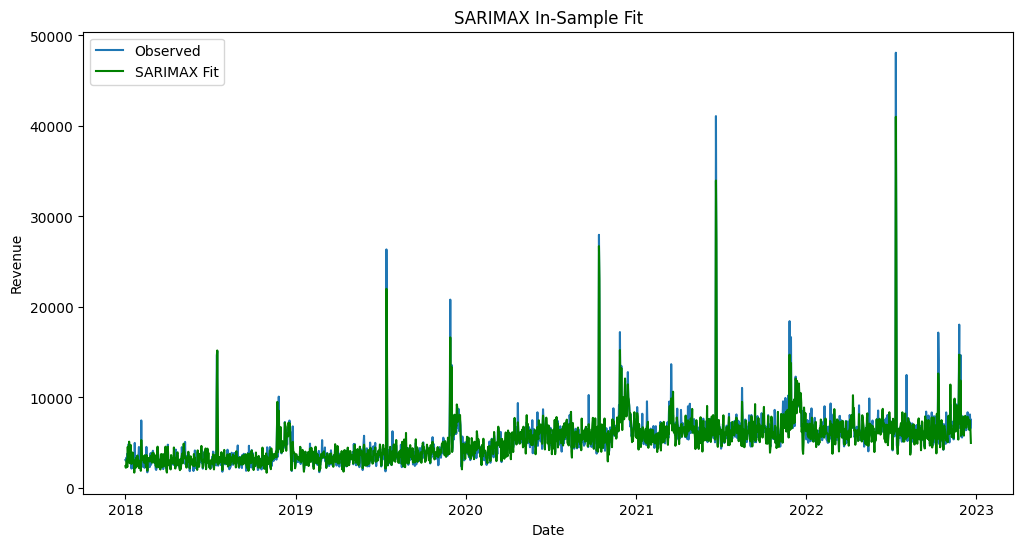

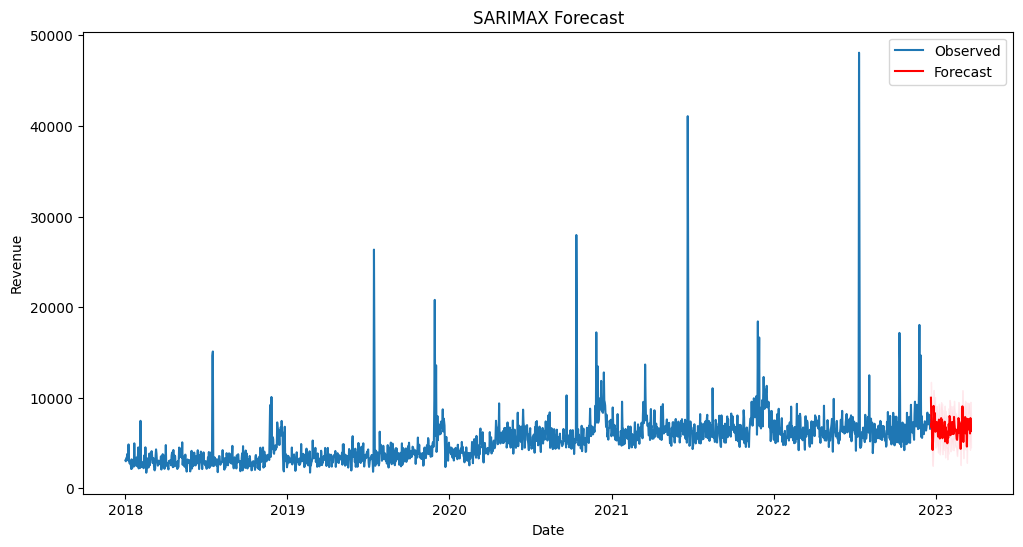

In [36]:
#SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming aggregated_data is already loaded in the notebook
# Ensure the data is sorted by the index
aggregated_data = aggregated_data.sort_index()
aggregated_data.rename(columns={'Day of Week': 'Weekday'}, inplace=True)

exog_vars = aggregated_data[['prime_proportion', 'Prime Purchase', 'Prime Customer']]
# Fit SARIMAX Model
model = SARIMAX(aggregated_data["Revenue"], 
                order=(1, 1, 1),  # p, d, q
                seasonal_order=(1, 1, 1, 7),  # P, D, Q, s 
                exog=exog_vars)  # Exogenous variables
result = model.fit()

# Summary of the model
print(result.summary())

# Generate in-sample predictions
in_sample_predictions = result.predict(start=aggregated_data.index[0], end=aggregated_data.index[-1], exog=exog_vars)

# Forecast steps
days_in_month = 365 / 12
forecast_steps = int(3 * days_in_month)  # Forecast for 12 months

# Assuming you have future exogenous variables for the forecast period
# If not, you can use the last available exogenous variables or create a placeholder
exog_forecast = exog_vars.loc[pd.to_datetime('2021-12-21'):pd.to_datetime('2021-12-21') + pd.Timedelta(days=90)]

# Forecast
forecast = result.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the original data and the SARIMAX in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(in_sample_predictions, label="SARIMAX Fit", color='green')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX In-Sample Fit')
plt.legend()
plt.show()

# Plot the original data and the SARIMAX forecast
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(forecast_values, label="Forecast", color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

In [37]:
# Calculate accuracy metrics
mae = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

avg_revenue = aggregated_data["Revenue"].mean()
print(f"Average Revenue: {avg_revenue:.2f}")
print(f"MAE as % of Avg Revenue: {mae / avg_revenue * 100:.2f}%")
print(f"RMSE as % of Avg Revenue: {rmse / avg_revenue * 100:.2f}%")

Mean Absolute Error (MAE): 619.15
Root Mean Squared Error (RMSE): 894.41
Average Revenue: 5276.44
MAE as % of Avg Revenue: 11.73%
RMSE as % of Avg Revenue: 16.95%


In [38]:
x

,Year,Month,Day
0,2018,1,1
1,2018,1,2
2,2018,1,3
3,2018,1,4
4,2018,1,5
...,...,...,...
1810,2022,12,16
1811,2022,12,17
1812,2022,12,18
1813,2022,12,19


# Prediction & Validation

In [39]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the actual revenue data
fig.add_trace(go.Scatter(x=revenue.index, y=revenue, mode='lines', name='Actual Revenue', line=dict(color='blue')))

# Add the Exponential Smoothing model
fig.add_trace(go.Scatter(x=combined_data.index, y=combined_data['Model'], mode='lines', name='Exponential Smoothing Model', line=dict(color='red')))

# Add the SARIMAX model
fig.add_trace(go.Scatter(x=aggregated_data.index, y=in_sample_predictions, mode='lines', name='SARIMAX Model', line=dict(color='green')))

# Add the GAM model
fig.add_trace(go.Scatter(x=x.index, y=gam.predict(x), mode='lines', name='GAM Model', line=dict(color='purple')))

# Update layout
fig.update_layout(title='Revenue Model Comparison',
                  xaxis_title='Date',
                  yaxis_title='Revenue',
                  template='plotly_white')

# Add the Exponential Smoothing forecast
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Exponential Smoothing Forecast', line=dict(color='red'), opacity=0.7))

# Add the SARIMAX forecast
fig.add_trace(go.Scatter(x=forecast_values.index, y=forecast_values, mode='lines', name='SARIMAX Forecast', line=dict(color='green'), opacity=0.7))

# Add the GAM forecast
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions, mode='lines', name='GAM Forecast', line=dict(color='purple'), opacity=0.7))

# Show the plot
fig.show()


In [40]:
# Residual Plots

import plotly.express as px
import plotly.graph_objects as go

# Residual plot for GAM
gam_residuals = gam.deviance_residuals(x.iloc[:, :5], y)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y, y=gam_residuals, mode='markers', name='GAM Residuals', marker=dict(color='blue', opacity=0.4)))

# Residual plot for Exponential Smoothing Model
exp_residuals = expModel.resid
fig.add_trace(go.Scatter(x=revenue, y=exp_residuals, mode='markers', name='Exponential Smoothing Residuals', marker=dict(color='red', opacity=0.4)))

# Residual plot for SARIMAX Model
sarimax_residuals = aggregated_data["Revenue"] - in_sample_predictions
fig.add_trace(go.Scatter(x=aggregated_data["Revenue"], y=sarimax_residuals, mode='markers', name='SARIMAX Residuals', marker=dict(color='green', opacity=0.4)))

# Update layout once at the end
fig.update_layout(title='Residual Plot for Models', xaxis_title='Observed', yaxis_title='Residuals')

fig.show()

In [41]:
# Calculate accuracy metrics
mae = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

avg_revenue = aggregated_data["Revenue"].mean()
print(f"Average Revenue: {avg_revenue:.2f}")
print(f"MAE as % of Avg Revenue: {mae / avg_revenue * 100:.2f}%")
print(f"RMSE as % of Avg Revenue: {rmse / avg_revenue * 100:.2f}%")
# Calculate accuracy metrics for Exponential Smoothing model
mae_exp = mean_absolute_error(revenue, expModel.fittedvalues)
rmse_exp = np.sqrt(mean_squared_error(revenue, expModel.fittedvalues))

print(f"Exponential Smoothing - Mean Absolute Error (MAE): {mae_exp:.2f}")
print(f"Exponential Smoothing - Root Mean Squared Error (RMSE): {rmse_exp:.2f}")

# Calculate accuracy metrics for SARIMAX model
mae_sarimax = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse_sarimax = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"SARIMAX - Mean Absolute Error (MAE): {mae_sarimax:.2f}")
print(f"SARIMAX - Root Mean Squared Error (RMSE): {rmse_sarimax:.2f}")

# Calculate accuracy metrics for GAM model
mae_gam = mean_absolute_error(y_test, y_pred)
rmse_gam = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"GAM - Mean Absolute Error (MAE): {mae_gam:.2f}")
print(f"GAM - Root Mean Squared Error (RMSE): {rmse_gam:.2f}")

Mean Absolute Error (MAE): 619.15
Root Mean Squared Error (RMSE): 894.41
Average Revenue: 5276.44
MAE as % of Avg Revenue: 11.73%
RMSE as % of Avg Revenue: 16.95%
Exponential Smoothing - Mean Absolute Error (MAE): 1019.10
Exponential Smoothing - Root Mean Squared Error (RMSE): 2162.65
SARIMAX - Mean Absolute Error (MAE): 619.15
SARIMAX - Root Mean Squared Error (RMSE): 894.41
GAM - Mean Absolute Error (MAE): 1018.64
GAM - Root Mean Squared Error (RMSE): 1793.36


# Recommendation

In [109]:
#Sarimax Forecast
sum(forecast_values)

611935.8253139433

In [42]:
average_prices = subset_data.groupby(['Category','Prime Purchase'])['Revenue'].mean()

# Calculate the difference in mean between prime purchase 0 and 1 for each category
average_prices_diff = average_prices.unstack().diff(axis=1).iloc[:, -1].reset_index()
average_prices_diff.columns = ['Category', 'Difference']
# Calculate prime purchase quantities
prime_purchase_quantities = subset_data.groupby(['Category', 'Prime Purchase'])['Quantity'].sum().unstack().reset_index()
# Calculate the proportion of purchase quantities
prime_purchase_quantities.columns = ['Category', 'Non-Prime Purchase Quantity', 'Prime Purchase Quantity']
prime_purchase_quantities['Proportion'] = prime_purchase_quantities['Prime Purchase Quantity'] / (prime_purchase_quantities['Non-Prime Purchase Quantity'] + prime_purchase_quantities['Prime Purchase Quantity'])


# Merge with average_prices_diff to display the results together
average_prices_diff = pd.merge(average_prices_diff, prime_purchase_quantities, on='Category', how='left')

# Display the top 40 values
top_differences = average_prices_diff
top_differences = top_differences[(top_differences['Difference'] > 0) & (top_differences['Proportion'] > 0.035)]
top_differences.head(40)

,Category,Difference,Non-Prime Purchase Quantity,Prime Purchase Quantity,Proportion
9,ABIS_EBOOKS,3.000000,1.0,3.0,0.750000
11,ABIS_HOME,6.298750,8.0,1.0,0.111111
21,ABIS_WIRELESS,362.570000,2.0,2.0,0.500000
38,AIR_FRYER,3.411294,86.0,10.0,0.104167
44,ALARM,9.675385,31.0,3.0,0.088235
46,AMAZON_BOOK_READER,1.289647,93.0,16.0,0.146789
47,AMAZON_BOOK_READER_ACCESSORY,0.160439,41.0,5.0,0.108696
48,AMAZON_DEVICE,86.472941,35.0,4.0,0.102564
49,AMAZON_TABLET,40.291436,250.0,40.0,0.137931
50,AMAZON_TABLET_ACCESSORY,1.828079,108.0,19.0,0.149606


In [43]:
# Get the unique categories in subset_data
subset_categories = set(subset_data['Category'].unique())

# Get the categories in top_differences
top_differences_categories = set(top_differences['Category'].unique())

# Find the categories in subset_data that are not in top_differences
categories_not_in_top_differences = subset_categories - top_differences_categories

# Count the number of such categories
num_categories_not_in_top_differences = len(categories_not_in_top_differences)
num_categories_not_in_top_differences

1600

In [44]:
# Filter the data for the category "DIGITAL_DEVICE_3"
top_products_data = subset_data[subset_data['Category'].isin(top_differences['Category'])]

# Plot the distribution of prices for "HEALTH_PERSONAL_CARE" colored by prime purchase using plotly express
fig = px.histogram(top_products_data, x='Purchase Price Per Unit', color='Prime Purchase', nbins=50, marginal='box', title='Distribution of Prices for Top Products by Prime Purchase')
fig.update_layout(xaxis_title='Purchase Price Per Unit', yaxis_title='Frequency')
fig.show()

In [ ]:
# Take a subset of the data for the top categories for prime day sales
subset_data_with_top_diff = subset_data[subset_data['Category'].isin(top_differences['Category'])]

In [46]:
# Group by cluster and Date and aggregate the quantity and purchase prices
aggregated_diff_data = subset_data_with_top_diff.groupby(['Order Date']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'Prime Purchase': lambda x: 1 if x.sum() > 0 else 0,
    'Prime Customer': 'sum'
}).reset_index()

# Add a column for the year, month, day, and day of the week
aggregated_diff_data['Year'] = aggregated_diff_data['Order Date'].dt.year
aggregated_diff_data['Month'] = aggregated_diff_data['Order Date'].dt.month
aggregated_diff_data['Day'] = aggregated_diff_data['Order Date'].dt.day
aggregated_diff_data['Day of Week'] = aggregated_diff_data['Order Date'].dt.dayofweek

# Display the first few rows of the aggregated data
aggregated_diff_data['prime_proportion'] = aggregated_diff_data['Prime Customer'] / aggregated_diff_data['Quantity']
aggregated_diff_data.head()

,Order Date,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
0,2018-01-01,1.0,5.99,0,1,2018,1,1,0,1.0
1,2018-01-02,2.0,22.99,0,2,2018,1,2,1,1.0
2,2018-01-03,10.0,167.02,0,8,2018,1,3,2,0.8
3,2018-01-04,2.0,129.94,0,2,2018,1,4,3,1.0
4,2018-01-05,1.0,12.48,0,1,2018,1,5,4,1.0


In [ ]:
#Forecast the sale quantities for top prime products in the next 3 months

#Set the index to the date column
aggregated_diff_data.set_index('Order Date', inplace=True)

# Extract the Revenue series
revenue_diff = aggregated_diff_data['Quantity']
revenue_diff.index = aggregated_diff_data.index

# Fit the Exponential Smoothing model
exp_model_diff = ExponentialSmoothing(revenue_diff, trend='add', seasonal='add', seasonal_periods=30).fit()

# Generate the fitted values and forecast
fitted_values_diff = exp_model_diff.fittedvalues
forecast_diff = exp_model_diff.forecast(90)

# Create a DataFrame with the actual revenue, fitted values, and forecast
combined_data_diff = pd.DataFrame({
    'Actual': revenue_diff,
    'Fitted': fitted_values_diff
}, index=revenue_diff.index)

# Add the forecast to the DataFrame
forecast_dates_diff = pd.date_range(start=revenue_diff.index[-1], periods=90, freq='D')
forecast_df_diff = pd.DataFrame({
    'Forecast': forecast_diff
}, index=forecast_dates_diff)

# Combine the actual, fitted, and forecast data
combined_data_diff = pd.concat([combined_data_diff, forecast_df_diff])

# Plot the data using Plotly
fig = px.line(combined_data_diff, y=['Actual', 'Fitted', 'Forecast'], 
              title='Exponential Smoothing Forecast on Aggregated Diff Data', 
              labels={'value': 'Quantity', 'variable': 'Type'},
              x=combined_data_diff.index,
              color_discrete_map={
                  "Actual": 'blue',
                  'Fitted': 'red',
              })

# Add the forecast to the plot
fig.add_scatter(x=forecast_dates_diff, y=forecast_diff, mode='lines', name='Forecast', line=dict(color='green'))

fig.show()

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [ ]:
# Calculate Expected Quantities
sum(forecast_diff) * 1.035, sum(forecast_diff) * 1.1, sum(forecast_diff) * 1 # 3.5% increase, 10% increase, no increase

(896.7759447636711, 953.0952069952061, 866.4501881774601)

In [ ]:
#3.5 % quantity increase
sampled_prices = np.array([])   
sample_rest = np.array([])

# Sample with replacement from different distributions (AGGRESIVE)
for i in range(0, 10):
    # Sample 897 items from the 'Purchase Price Per Unit' column
    sample_1 = top_products_data[top_products_data['Prime Purchase']==1]['Purchase Price Per Unit'].sample(n=897, random_state=42+i, replace=True)
    sampled_prices = np.append(sampled_prices, sum(sample_1))
    # Sample 866 items from the 'Purchase Price Per Unit' column
    sample_2 = top_products_data['Purchase Price Per Unit'].sample(n=866, random_state=42+i, replace=True)
    sample_rest = np.append(sample_rest, sum(sample_2))

# Sample without replacement from the same distribution
for i in range(0, 10):
# Sample 897 items from the 'Purchase Price Per Unit' column
    sample_3 = top_products_data['Purchase Price Per Unit'].sample(n=897, random_state=42+i)
    sampled_prices = np.append(sampled_prices, sum(sample_3))
    # Sample 866 items from the 'Purchase Price Per Unit' column
    sample_4 = top_products_data['Purchase Price Per Unit'].sample(n=866, random_state=42+i)
    sample_rest = np.append(sample_rest, sum(sample_4))


# Display the sampled prices
sampled_prices[0:10] - sample_rest[0:10], sampled_prices[10:20] - sample_rest[10:20], np.mean(sampled_prices[0:10] - sample_rest[0:10]), np.mean(sampled_prices[10:20] - sample_rest[10:20])

(array([26565.67, 13564.71, 21810.66, 21922.59, 25705.55, 23784.88,
        26237.03, 18718.04, 19899.81, 30578.35]),
 array([1609.64, 1776.14,  867.82, 1495.9 ,  812.9 , 1540.52, 2277.54,
        2000.73, 1730.62, 1251.65]),
 22878.729,
 1536.346)

In [116]:
#10 % quantity increase
sampled_prices = np.array([])   
sample_rest = np.array([])

# Sample with replacement from different distributions (AGGRESIVE)
for i in range(0, 10):
    # Sample 897 items from the 'Purchase Price Per Unit' column
    sample_1 = top_products_data[top_products_data['Prime Purchase']==1]['Purchase Price Per Unit'].sample(n=953, random_state=42+i, replace=True)
    sampled_prices = np.append(sampled_prices, sum(sample_1))
    # Sample 866 items from the 'Purchase Price Per Unit' column
    sample_2 = top_products_data['Purchase Price Per Unit'].sample(n=866, random_state=42+i, replace=True)
    sample_rest = np.append(sample_rest, sum(sample_2))

# Sample without replacement from the same distribution
for i in range(0, 10):
# Sample 897 items from the 'Purchase Price Per Unit' column
    sample_3 = top_products_data['Purchase Price Per Unit'].sample(n=953, random_state=42+i)
    sampled_prices = np.append(sampled_prices, sum(sample_3))
    # Sample 866 items from the 'Purchase Price Per Unit' column
    sample_4 = top_products_data['Purchase Price Per Unit'].sample(n=866, random_state=42+i)
    sample_rest = np.append(sample_rest, sum(sample_4))


# Display the sampled prices
sampled_prices[0:10] - sample_rest[0:10], sampled_prices[10:20] - sample_rest[10:20], np.mean(sampled_prices[0:10] - sample_rest[0:10]), np.mean(sampled_prices[10:20] - sample_rest[10:20])

(array([30199.29, 17287.61, 27186.55, 26060.68, 29284.34, 27431.59,
        30559.14, 23632.12, 23587.11, 35071.71]),
 array([4233.57, 4099.38, 2726.77, 3963.77, 2704.42, 5686.18, 5255.4 ,
        5291.23, 3918.52, 4316.35]),
 27030.014000000003,
 4219.558999999999)

The above shows a 3.5 % increase in sale quantities for products showing at least 3.5 of all sales happened on prime day over the last 5 years as well as price distributions being greater than 0. 

The 22878 number was the average difference in sum of sales using sampling with replacement and prime day pricing strategy.

The 1536 number was the average difference in sum of sales using sampling without replacement and no difference in pricing. 

We then suggest that prime day related marketing on these select products may lead to at least a 3.5 % increase in sale quantities. At no pricing change, this would be about a $1500 increase over the 90 day period. If prices follow the distribution of prime day purchasing behaviors, we may expect around a $23,000 increase in sales over the period.